In [203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv ('https://raw.githubusercontent.com/ITACADEMYprojectes/projecteML/refs/heads/main/bank_dataset.CSV')

In [204]:
# Para tratar los outliers se aplicará la técnica de Winsorización para mantener la estructura del dataset
# Función para calcular límites IQR
def calculate_iqr_limits(df, columns):
    limits_dict = {}

    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        limits_dict[column] = (lower_bound, upper_bound)

    return limits_dict

In [205]:
# Función para winsorizar datos
def winsorize_data(df, columns):
    limits_dict = calculate_iqr_limits(df, columns)

    for column, (lower_bound, upper_bound) in limits_dict.items():
        # Winsorizar: Reemplazar valores menores que el límite inferior y mayores que el límite superior
        df[column] = np.clip(df[column], lower_bound, upper_bound)

    return df

In [206]:
#completem els valors categorics desconeguts amb "unknown" i els buits en l'edat per la moda
df['marital'] = df["marital"].fillna("unknown")
df['education'] = df["education"].fillna("unknown")
df['age'] = df['age'].fillna(df['age'].mode()[0])
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        11162 non-null  float64
 1   job        11162 non-null  object 
 2   marital    11162 non-null  object 
 3   education  11162 non-null  object 
 4   default    11162 non-null  object 
 5   balance    11162 non-null  int64  
 6   housing    11162 non-null  object 
 7   loan       11162 non-null  object 
 8   contact    11162 non-null  object 
 9   day        11162 non-null  int64  
 10  month      11162 non-null  object 
 11  duration   11162 non-null  int64  
 12  campaign   11162 non-null  int64  
 13  pdays      11162 non-null  int64  
 14  previous   11162 non-null  int64  
 15  poutcome   11162 non-null  object 
 16  deposit    11162 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


In [207]:
df.deposit.value_counts() #Podem considerar de les dades estan balancejades

,count
deposit,
no,5873
yes,5289


**Comentari retroaccio entrega 6:**
Cuando las variables categóricas tienen múltiples categorías, se puede utilizar Label Encoding para evitar el aumento de dimensionalidad asociado con One-Hot Encoding.
Te sugiero que para la variable "educación", primero agrupes las categorías en niveles más generales (por ejemplo, "Básica", "Secundaria" y "Superior") y luego utilices Label Encoding, asignando números como 1, 2, 3, etc., a cada nivel educativo según su orden (de menor a mayor nivel). Esto se debe a que "educación" es una variable ordinal, donde el orden de las categorías tiene un significado. --> codifiquem "education" de 0-3

In [208]:
#reduim la dimensionalitat en totes les variable categoriques

#reduim les dimensions de job
valor_others = df['job'].isin(['unemployed', 'unknown', 'housemaid', 'entrepreneur'])
df.loc[valor_others, 'job'] = 'others'
df['job'] = df['job'].astype('category')

#reduim les dimensions de marital
valor_others = df['marital'].isin(['divorced', 'unknown'])
df.loc[valor_others, 'marital'] = 'others'
df['marital']=df['marital'].astype('category')

#reduim les dimensions de education
education_={'unknown':0,'primary':1,'secondary':2,'tertiary':3}
df['education']=df['education'].map(education_)

default_={'yes':1,'no':0}
df['default']=df['default'].map(default_)

housing_={'yes':1,'no':0}
df['housing']=df['housing'].map(housing_)

loan_={'yes':1,'no':0}
df['loan']=df['loan'].map(loan_)

#reduim les dimensions de contact
valor_others = df['contact'].isin(['unknown','telephone'])
df.loc[valor_others, 'contact'] = 'others'

#reduir les dimensions de poutcome
valor_others = df['poutcome'].isin(['unknown','other'])
df.loc[valor_others, 'poutcome'] = 'others'

deposit_={'yes':1,'no':0}
df['deposit']=df['deposit'].map(deposit_)

df.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59.0,admin.,married,2,0,2343,1,0,others,5,may,1042,1,-1,0,others,1
1,56.0,admin.,married,2,0,45,0,0,others,5,may,1467,1,-1,0,others,1
2,41.0,technician,married,2,0,1270,1,0,others,5,may,1389,1,-1,0,others,1
3,55.0,services,married,2,0,2476,1,0,others,5,may,579,1,-1,0,others,1
4,54.0,admin.,married,3,0,184,0,0,others,5,may,673,2,-1,0,others,1


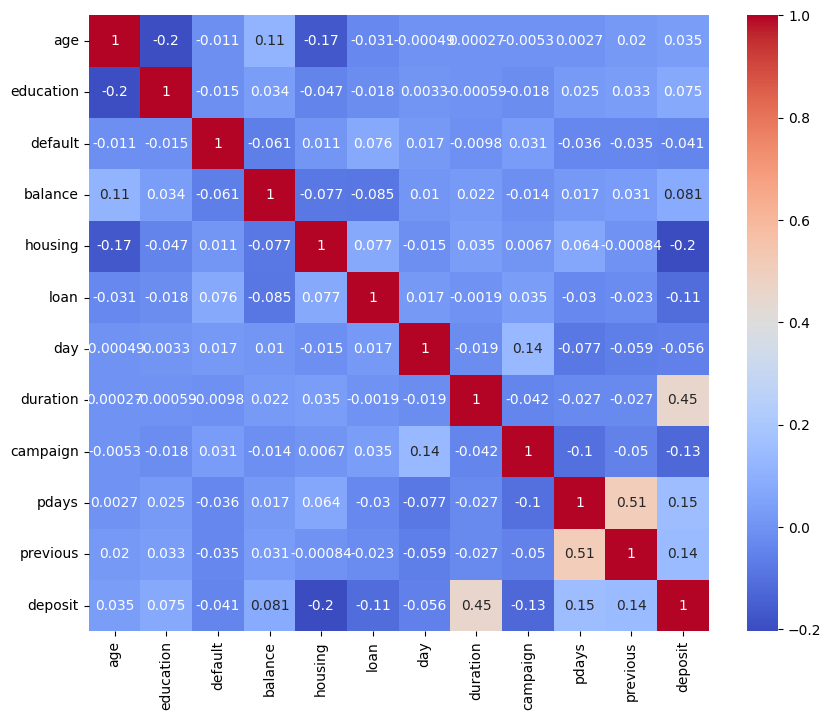

In [209]:
data_numeric = df.select_dtypes(include=['number'])
corr_matrix = data_numeric.corr()
# Mostrar la correlación entre características y la variable objetivo
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [210]:

# Codificacio Categorica One-Hot
from sklearn.preprocessing import OneHotEncoder

codificador = OneHotEncoder()
codificacion = codificador.fit_transform(df[['job', 'marital','contact','month','poutcome']])

new_columns = pd.DataFrame(codificacion.toarray(),
                    columns=codificador.get_feature_names_out())

combined_df = pd.concat([df, new_columns], axis=1)
df = combined_df.drop(['job', 'marital','contact','month','poutcome'], axis=1)
df.head()

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,previous,deposit,job_admin.,job_blue-collar,job_management,job_others,job_retired,job_self-employed,job_services,job_student,job_technician,marital_married,marital_others,marital_single,contact_cellular,contact_others,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_others,poutcome_success
0,59.0,2,0,2343,1,0,5,1042,1,-1,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,56.0,2,0,45,0,0,5,1467,1,-1,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,41.0,2,0,1270,1,0,5,1389,1,-1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,55.0,2,0,2476,1,0,5,579,1,-1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,54.0,3,0,184,0,0,5,673,2,-1,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [211]:
print(df.columns)
print(df.shape)

Index(['age', 'education', 'default', 'balance', 'housing', 'loan', 'day',
       'duration', 'campaign', 'pdays', 'previous', 'deposit', 'job_admin.',
       'job_blue-collar', 'job_management', 'job_others', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'marital_married', 'marital_others', 'marital_single',
       'contact_cellular', 'contact_others', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_others', 'poutcome_success'],
      dtype='object')
(11162, 41)


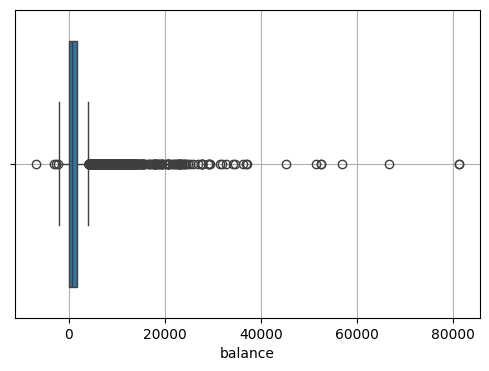

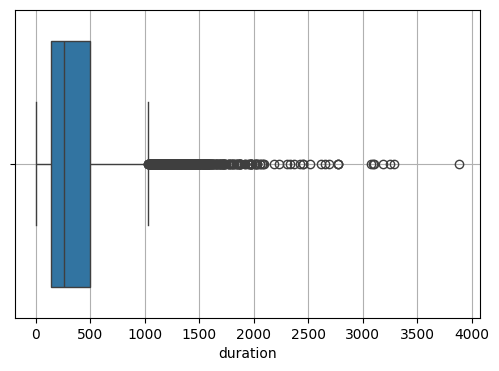

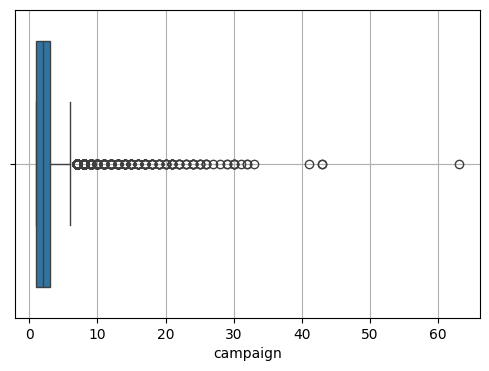

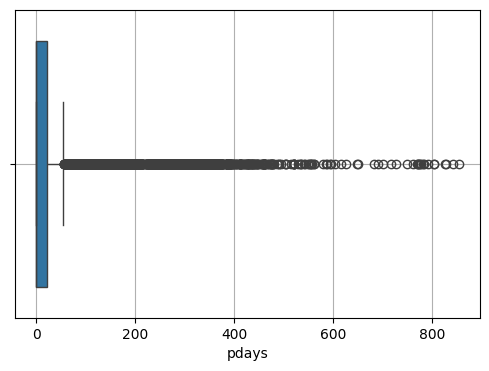

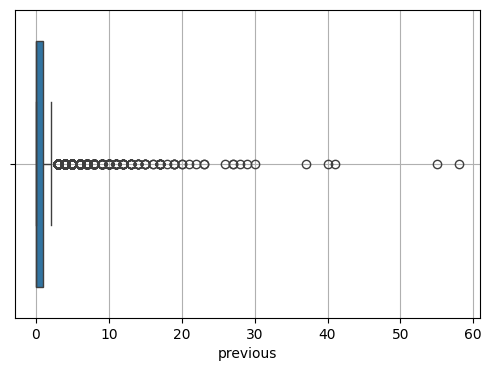

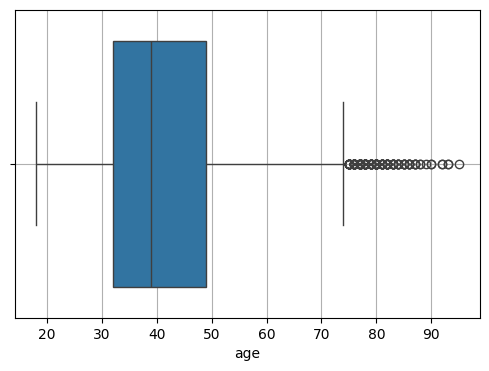

In [212]:
#Chech outliners

columns_to_check = ['balance', 'duration', 'campaign', 'pdays', 'previous', 'age']
# Crear diagramas de caja para visualizar outliers en cada columna
for column in columns_to_check:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[column])
    plt.xlabel(column)
    plt.grid(True)
    plt.show() # Se detectaron outliers en todas las columnas señaladas

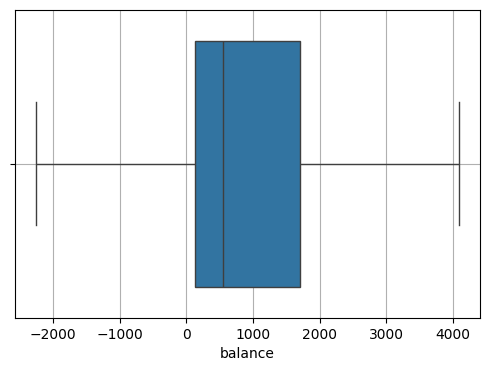

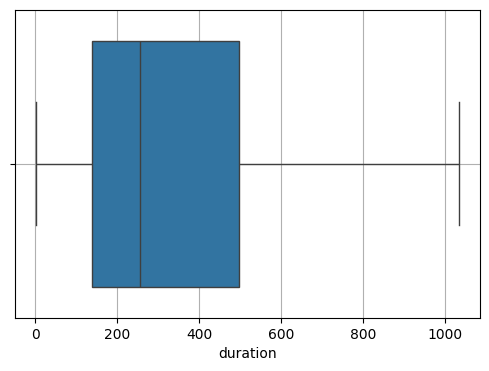

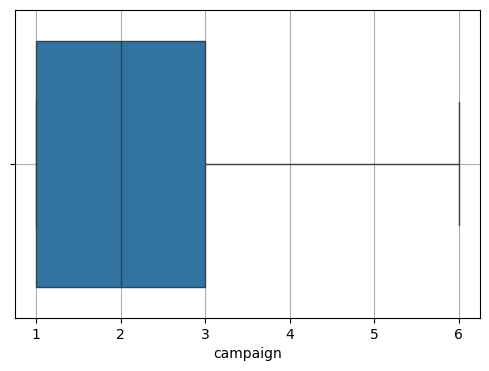

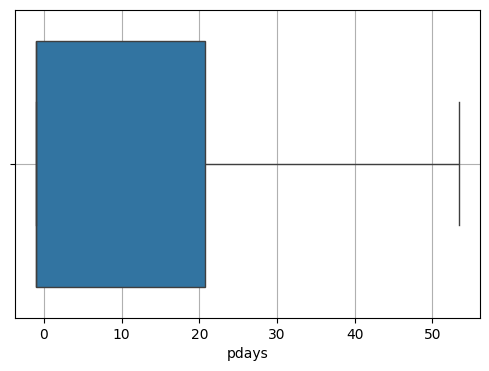

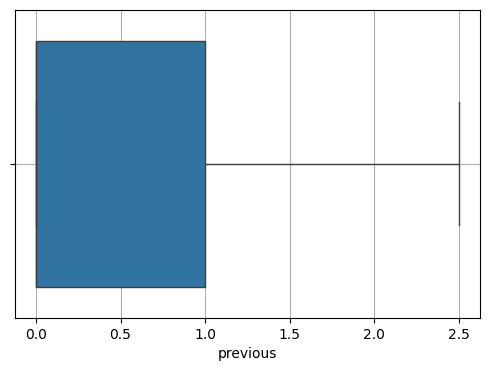

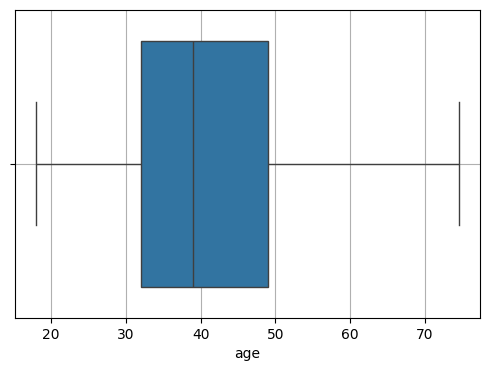

In [213]:
df = winsorize_data(df, columns_to_check)
for column in columns_to_check:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[column])
    plt.xlabel(column)
    plt.grid(True)
    plt.show() # Se detectaron outliers en todas las columnas señaladas

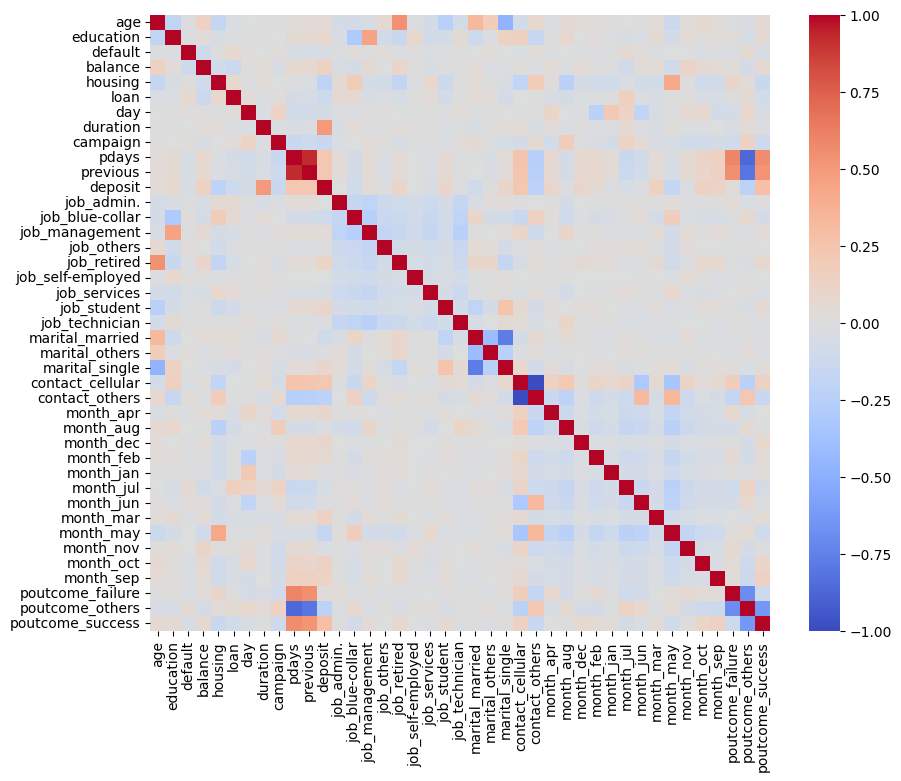

In [214]:
data_numeric = df.select_dtypes(include=['number'])
corr_matrix = data_numeric.corr()
# Mostrar la correlación entre características y la variable objetivo
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.show()


In [215]:
# Sel·leccionar subconjunts de dades d'entrenament i de prova
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

y=df['deposit']
X=df.loc[:, df.columns != 'deposit']


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, # 80% assignat a entrenament + 20% assignat a test
                                                    random_state=0, # seleccionar dades aleatoriament
                                                    stratify=y) # mantenir la mateixa distribucio èxit/fracàs en ambdos conjunts

X.shape, X_train.shape, X_test.shape,y_train.shape, y_test.shape

((11162, 40), (8929, 40), (2233, 40), (8929,), (2233,))

**comentari retroaccio entrega 6:** solo debes escalar las caracteristica numéricas. Por otro lado, es importante el orden. Aplica el escalador y PCA después de dividir el conjunto de datos: ajusta en el conjunto de entrenamiento y transforma el conjunto de prueba.

In [216]:
# Escalem el conjunt de les dades X_train
scaler = StandardScaler()
columns_to_standarize = ['age','balance', 'day','duration', 'campaign', 'pdays', 'previous']
X_train[columns_to_standarize] = scaler.fit_transform(X_train[columns_to_standarize])
X_train.describe()


,age,education,default,balance,housing,loan,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_management,job_others,job_retired,job_self-employed,job_services,job_student,job_technician,marital_married,marital_others,marital_single,contact_cellular,contact_others,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_others,poutcome_success
count,8.929000e+03,8929.000000,8929.000000,8.929000e+03,8929.000000,8929.000000,8.929000e+03,8.929000e+03,8.929000e+03,8.929000e+03,8.929000e+03,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000
mean,-9.350294e-17,2.103707,0.015119,3.103502e-17,0.474185,0.131146,1.066331e-16,-7.161927e-18,1.591539e-18,-4.695041e-17,2.387309e-18,0.118938,0.172136,0.229701,0.095643,0.069549,0.036286,0.082092,0.032030,0.163624,0.570725,0.116138,0.313137,0.719229,0.280771,0.081644,0.136633,0.009856,0.067533,0.032254,0.134618,0.109867,0.023183,0.254452,0.085564,0.035166,0.029231,0.110875,0.792810,0.096315
std,1.000056e+00,0.797760,0.122034,1.000056e+00,0.499361,0.337579,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,0.323734,0.377520,0.420664,0.294118,0.254399,0.187012,0.274520,0.176091,0.369955,0.495000,0.320409,0.463796,0.449401,0.449401,0.273837,0.343479,0.098790,0.250956,0.176685,0.341334,0.312741,0.150492,0.435577,0.279735,0.184210,0.168462,0.313994,0.405316,0.295040
min,-1.988111e+00,0.000000,0.000000,-2.502615e+00,0.000000,0.000000,-1.743360e+00,-1.235273e+00,-8.152427e-01,-5.767533e-01,-5.421150e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.842287e-01,2.000000,0.000000,-7.392543e-01,0.000000,0.000000,-9.113039e-01,-7.569983e-01,-8.152427e-01,-5.767533e-01,-5.421150e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,-1.822878e-01,2.000000,0.000000,-4.210036e-01,0.000000,0.000000,-7.924787e-02,-3.420243e-01,-1.581474e-01,-5.767533e-01,-5.421150e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,6.776277e-01,3.000000,0.000000,4.358253e-01,1.000000,0.000000,7.528081e-01,4.984740e-01,4.989480e-01,-1.073261e-01,5.811115e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,2.870412e+00,3.000000,1.000000,2.203637e+00,1.000000,1.000000,1.822594e+00,2.390474e+00,2.470234e+00,1.743711e+00,2.265951e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


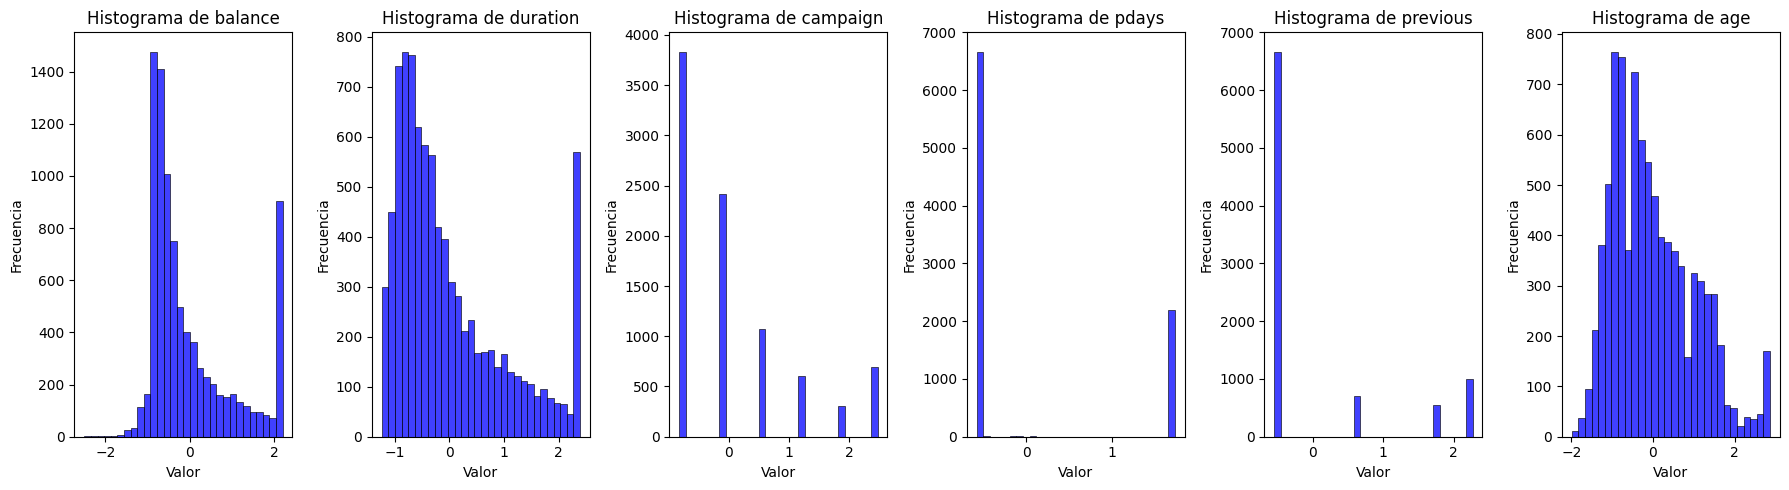

In [217]:
#Chequear el resultado con histogramas para ver media 0 y desvío estándar=1
# Crear una figura con subgráficos para cada columna numérica
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(18, 5))
# Definir las columnas para visualizar
columns_to_plot = ['balance', 'duration', 'campaign', 'pdays', 'previous', 'age']
# Iterar sobre cada columna para crear un histograma
for i, column in enumerate(columns_to_plot):
    sns.histplot(X_train[column], kde=False, ax=axes[i], color='blue', bins=30)
    axes[i].set_title(f'Histograma de {column}')
    axes[i].set_xlabel('Valor')
    axes[i].set_ylabel('Frecuencia')
# Ajustar el diseño
plt.tight_layout()
plt.show()


In [218]:
# Apliquem PCA al conjunt de entrenament
pca = PCA(n_components=0.90)
X_train = pca.fit_transform(X_train)
X_train.shape

(8929, 16)

In [219]:
# Escalem el conjunt de les dades X_test
#scaler = StandardScaler()
#columns_to_standarize = ['age','balance', 'day','duration', 'campaign', 'pdays', 'previous']
X_test[columns_to_standarize] = scaler.fit_transform(X_test[columns_to_standarize])
X_test.describe()

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_management,job_others,job_retired,job_self-employed,job_services,job_student,job_technician,marital_married,marital_others,marital_single,contact_cellular,contact_others,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_others,poutcome_success
count,2.233000e+03,2233.000000,2233.000000,2.233000e+03,2233.000000,2233.000000,2.233000e+03,2.233000e+03,2.233000e+03,2.233000e+03,2.233000e+03,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000
mean,-1.718285e-16,2.113300,0.014778,-3.341110e-17,0.468876,0.129422,-2.147856e-17,9.983555e-17,5.727617e-17,1.022221e-16,4.693464e-17,0.121809,0.182266,0.230631,0.078370,0.070309,0.036274,0.085087,0.033139,0.162114,0.561129,0.115987,0.322884,0.725481,0.274519,0.086879,0.133901,0.009852,0.077474,0.025078,0.139722,0.107927,0.030900,0.247201,0.080161,0.034931,0.025974,0.106583,0.798925,0.094492
std,1.000224e+00,0.789246,0.120692,1.000224e+00,0.499142,0.335742,1.000224e+00,1.000224e+00,1.000224e+00,1.000224e+00,1.000224e+00,0.327139,0.386150,0.421331,0.268813,0.255724,0.187013,0.279074,0.179040,0.368638,0.496360,0.320282,0.467684,0.446371,0.446371,0.281720,0.340622,0.098790,0.267402,0.156398,0.346776,0.310357,0.173086,0.431481,0.271603,0.183645,0.159093,0.308652,0.400894,0.292577
min,-1.974668e+00,0.000000,0.000000,-2.490855e+00,0.000000,0.000000,-1.730564e+00,-1.208455e+00,-8.103874e-01,-5.862766e-01,-5.507774e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.858095e-01,2.000000,0.000000,-7.305943e-01,0.000000,0.000000,-9.021677e-01,-7.540401e-01,-8.103874e-01,-5.862766e-01,-5.507774e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,-1.913803e-01,2.000000,0.000000,-4.164464e-01,0.000000,0.000000,4.457047e-02,-3.520577e-01,-1.516342e-01,-5.862766e-01,-5.507774e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,6.578044e-01,3.000000,0.000000,4.419294e-01,1.000000,0.000000,7.546241e-01,5.148261e-01,5.071190e-01,1.660128e+00,5.587273e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,2.823225e+00,3.000000,1.000000,2.187441e+00,1.000000,1.000000,1.819705e+00,2.381423e+00,2.483379e+00,1.718407e+00,2.222984e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [220]:
# Apliquem PCA al conjunt de test
#pca = PCA(n_components=0.90)
X_test = pca.fit_transform(X_test)
X_test.shape

(2233, 16)

In [221]:
## ENTRENAR EL MODELO
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Crear el modelo de regresión lineal
model = LogisticRegression()

model_score =cross_val_score(model,X_train,y_train, cv=5)
print(model_score)
print(model_score.mean())

[0.78387458 0.80963046 0.80291153 0.78387458 0.80291153 0.79395297
 0.80963046 0.79843225 0.79843225 0.78923767]
0.797288828406289


In [222]:
# Entrenar el modelo con los datos de entrenamiento completo
model.fit(X_train, y_train)

# Hacer predicciones con el conjunto de prueba
y_pred = model.predict(X_test)



In [223]:
def metricas(clases_reales, clases_predichas):
    """ Calcular las métricas utilizando sklearn """
    matriz = confusion_matrix(clases_reales, clases_predichas)
    accuracy = accuracy_score(clases_reales, clases_predichas)
    precision = precision_score(clases_reales, clases_predichas)
    recall = recall_score(clases_reales, clases_predichas)
    f1 = f1_score(clases_reales, clases_predichas)
    return matriz, accuracy, precision, recall, f1

def visualiza_metricas(clases_reales, clases_predichas, titulo):
    """ Visualiza la matriz de confusión y métricas """

    #Código para calcular las métricas y matriz de confusión

    matriz, accuracy, precision, recall, f1 = \
                    metricas(clases_reales, clases_predichas)

    #Código de matplotlib para graficar
    plt.figure(figsize=(3, 3))
    matriz = pd.DataFrame(matriz,
                          columns=["0 : No Deposit", "1 : Deposit"])
    plt.matshow(matriz, cmap="Blues", vmin=0, vmax=10, fignum=1)
    plt.title("Reales")
    plt.ylabel("Predichas")
    plt.xticks(range(len(matriz.columns)), matriz.columns, rotation=45)
    plt.yticks(range(len(matriz.columns)), matriz.columns)
    etiquetas = (("Verdaderos\nnegativos", "Falsos\npositivos"),
                 ("Falsos\nnegativos", "Verdaderos\npositivos"))
    for i in range(len(matriz.columns)):
        for j in range(len(matriz.columns)):
            plt.text(i, j + 0.14, str(matriz.iloc[i, j]),
                     fontsize=30, ha="center", va="center")
            plt.text(i, j - 0.25, etiquetas[i][j],
                     fontsize=11.5, ha="center", va="center")
    plt.text(1.60, -0.30, titulo, fontsize=25, c="red")
    plt.text(2.1, 0.10, "Accuracy: %0.2f" % accuracy, fontsize=20)
    plt.text(2.1, 0.40, "Precision: %0.2f" % precision, fontsize=20)
    plt.text(2.1, 0.70, "Recall: %0.2f" % recall, fontsize=20)
    plt.text(2.1, 1.00, "F1: %0.2f" % f1, fontsize=20)
    plt.show()

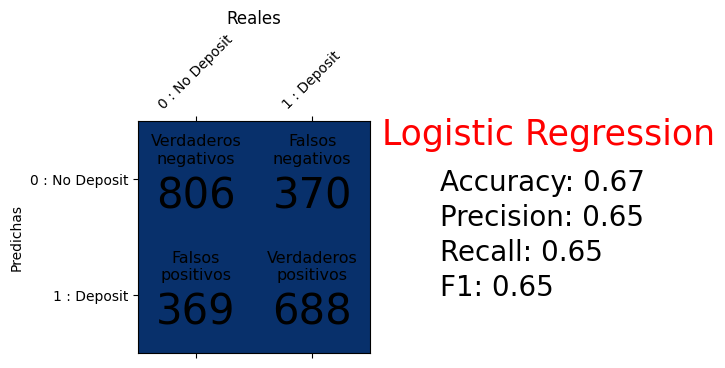

In [224]:
clases_reales = y_test
clases_predichas = y_pred

titulo = "Logistic Regression"
visualiza_metricas(clases_reales, clases_predichas, titulo)

##Comparem els resultats amb d'altres algoritmes de classificacio: Random Forest##


In [225]:
from sklearn.ensemble import RandomForestClassifier

bosque = RandomForestClassifier()
bosque_score =cross_val_score(bosque,X_train, y_train, cv=5)
print(bosque_score)
print(bosque_score.mean())

[0.80235162 0.81075028 0.81131019 0.8225084  0.81232493]
0.8118490845386306


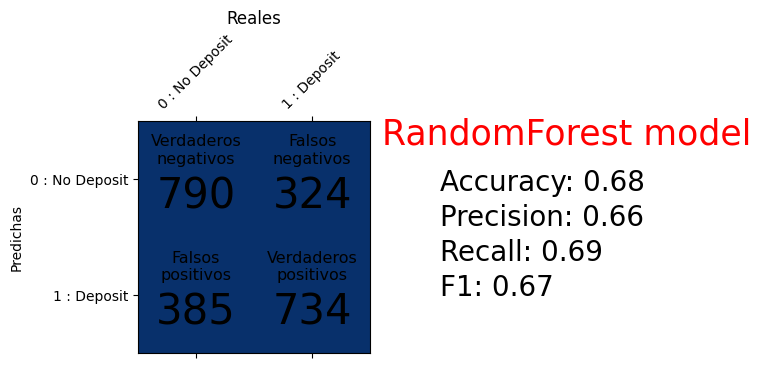

In [192]:
# Entrenar el modelo con los datos de entrenamiento completo
bosque.fit(X_train, y_train)

# Hacer predicciones con el conjunto de prueba
y_pred = bosque.predict(X_test)

clases_reales = y_test
clases_predichas = y_pred

titulo = "RandomForest model"
visualiza_metricas(clases_reales, clases_predichas, titulo)

# EL MODEL RANDOM FOREST AJUSTA MILLOR LA PREDICCIO DE LES DADES

## Provem d'ajustar alguns hiperparametres ##

In [193]:
bosque.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [195]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

parametros = {
    'max_features': ['sqrt', 'log2'],
    'criterion' :['gini', 'entropy']
}

rejilla= GridSearchCV(estimator=bosque, param_grid=parametros, cv= 5)
rejilla.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['sqrt', 'log2']})

In [196]:
print(rejilla.cv_results_["rank_test_score"])
print(rejilla.cv_results_["mean_test_score"])
print(rejilla.best_score_)
print(rejilla.best_params_)

[1 4 3 2]
[0.81532015 0.81341633 0.81386439 0.81397674]
0.8153201526971371
{'criterion': 'gini', 'max_features': 'sqrt'}


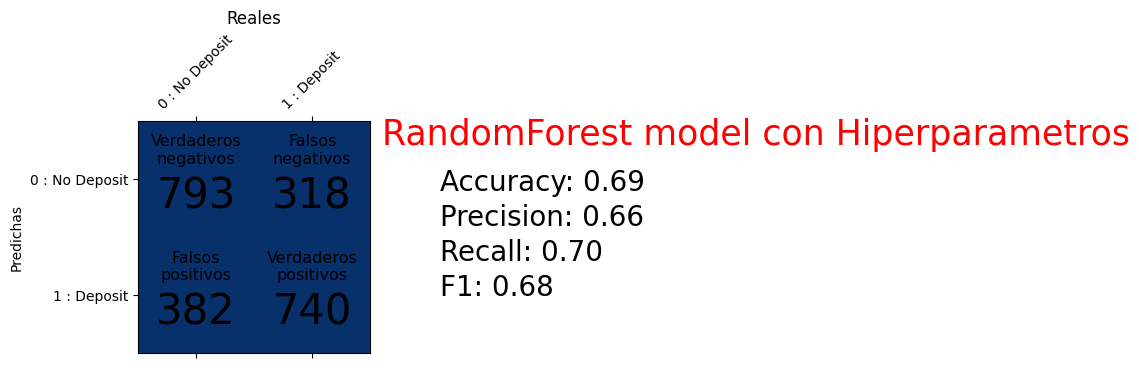

In [229]:
new_model = RandomForestClassifier(criterion='gini', max_features='sqrt')
new_model.fit(X_train, y_train)
y_pred = new_model.predict(X_test)
clases_reales = y_test
clases_predichas = y_pred

titulo = "RandomForest model con Hiperparametros"
visualiza_metricas(clases_reales, clases_predichas, titulo)

In [200]:
parametros = {
    'n_estimators': [100,200,300],
    'max_features': ['sqrt'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini']
}

rejilla_aleatorio= RandomizedSearchCV(bosque, parametros, scoring="accuracy", cv= 5, n_iter=3)
rejilla_aleatorio.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=3,
                   param_distributions={'criterion': ['gini'],
                                        'max_depth': [4, 5, 6, 7, 8],
                                        'max_features': ['sqrt'],
                                        'n_estimators': [100, 200, 300]},
                   scoring='accuracy')

In [202]:
print(rejilla_aleatorio.best_score_)
print(rejilla_aleatorio.best_params_)

0.8078168512645819
{'n_estimators': 300, 'max_features': 'sqrt', 'max_depth': 8, 'criterion': 'gini'}


## Conclusions: ##

- Hem verificat que les dades estaven balancejades
- Hem aplicat fet tractament dels valors nuls
- Hem fet tractament dels valors outliers amb winsoritzacio
- Hem aplicat Label Encoding o OneHotEncoding segons cada categoria
- Hem separat el DataSet en un conjunt d'entrenament 80% i test 20%
- Hem aplicat per separat escalat i PCA
- Hem comprovat com es comportaria l'algoritme de Regressio Logistica
- Hem comprovat com es comportaria l'algoritme de Random Forest
- Hem provat de modificat algun hiperparametre en forma de "rejilla" i "rejilla" aleatoria
- EL MILLOR RESULTAT OBTINGUT TE UNA PRECISSIÓ DEL 68%